# Chapter 4 - Frametrack cell tracking


## Here I'm going to introduce the Frametrack method. In Frametrack, we use the probability density of each frame to track the cells.

## The peak density in each frame is used as an aggregate cell position from which the trajectory is generated.

In [6]:
import movie_reader, laplacian_fitler, watershed, centroid_detection, kalman
import numpy as np
from scipy.stats import kde
import matplotlib.pyplot as plt
import cv2

## First we detect the cells using the method described in Chapter 3

In [5]:
movie = movie_reader.MoviePlayer('outz/out_12.avi')
frames, frame_width, frame_height = movie.read_movie()


def run_detection(img_frame):

    new_frame = laplacian_fitler.LaplacianSegmenter(img_frame, 62, 0).apply_filter()
    new_frame = watershed.WatershedTransform(new_frame).run_watershed()
    centroids = centroid_detection.CentroidDetector(new_frame).find_contours()

    return centroids, new_frame


detect = [run_detection(I) for n, I in enumerate(frames)]
cents = [i[0] for i in detect]
cents = [[j for j in i if [0,0] not in j] for i in cents]
fra = [i[1] for i in detect]



[[array([ 956, 1597]),
  array([ 867, 1597]),
  array([ 832, 1597]),
  array([ 787, 1597]),
  array([ 729, 1597]),
  array([ 685, 1597]),
  array([ 628, 1597]),
  array([ 618, 1597]),
  array([ 553, 1597]),
  array([ 528, 1597]),
  array([ 389, 1597]),
  array([ 298, 1597]),
  array([ 272, 1597]),
  array([ 229, 1597]),
  array([ 206, 1597]),
  array([ 169, 1597]),
  array([  76, 1597]),
  array([ 838, 1596]),
  array([ 534, 1596]),
  array([ 278, 1596]),
  array([ 238, 1596]),
  array([ 680, 1592]),
  array([ 384, 1592]),
  array([ 302, 1592]),
  array([   1, 1594]),
  array([  60, 1591]),
  array([ 796, 1588]),
  array([1000, 1587]),
  array([1008, 1584]),
  array([ 261, 1582]),
  array([1009, 1578]),
  array([   2, 1581]),
  array([ 760, 1577]),
  array([1014, 1579]),
  array([1540, 1576]),
  array([ 768, 1576]),
  array([1310, 1571]),
  array([1276, 1571]),
  array([ 107, 1572]),
  array([1541, 1570]),
  array([1536, 1568]),
  array([  10, 1568]),
  array([  14, 1560]),
  array([13

## Next, I made a KDE for each frame using cell centroids. I then extracted the position of peak density from each frame.

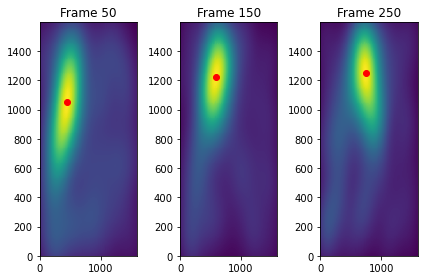

In [16]:
def get_grid(cents):
    all_cents = [i for j in cents for i in j]

    max_x = np.max([i[0] for i in all_cents])
    max_y = np.max([i[1] for i in all_cents])
    xi, yi = np.mgrid[0:max_x:250 * 1j, 0:max_y:250 * 1j]
    return xi, yi


max_x = []
max_y = []



xi, yi = get_grid(cents)

fig, ax = plt.subplots(1,3)
for n, i in enumerate(cents):
    ki = kde.gaussian_kde([[j[0] for j in cents[n]],[1600-j[1] for j in cents[n]]])
    zi = np.array(ki(np.vstack([xi.flatten(), yi.flatten()])))

    max_x.append(np.where(zi.reshape(xi.shape) == np.max(zi))[0])
    max_y.append(np.where(zi.reshape(xi.shape) == np.max(zi))[1])
    
    xp = xi[np.where(zi.reshape(xi.shape) == np.max(zi))[0]][0][0]
    yp = xi[np.where(zi.reshape(xi.shape) == np.max(zi))[1]][0][0]

    if n == 50:
        ax[0].pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax[0].scatter(xp, yp , c='r')
        ax[0].set_title('Frame 50')
    if n == 150: 
        ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax[1].scatter(xp, yp , c='r')
        ax[1].set_title('Frame 150')

    if n == 250:
        ax[2].pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax[2].scatter(xp, yp , c='r')
        ax[2].set_title('Frame 250')
plt.tight_layout()
        
    

## The peak density positions are what we use to generate the trajectories.

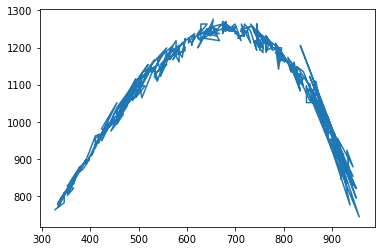

In [32]:
x_positions = xi[max_x][:,0,0]
y_positions = xi[max_y][:,0,0]

plt.plot(x_positions, y_positions)


## The trajectory is smoothened using a double-Kalman filter

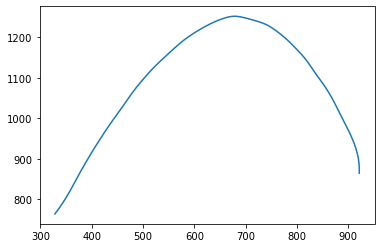

In [34]:
kf,_ = kalman.run_kf(x_positions, y_positions, 20)

plt.plot(kf[:,0], kf[:,2])